<a href="https://colab.research.google.com/github/Nikita-Gz/ArGen/blob/main/ArGen_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import colorsys
import os
import lzma
import shutil
import pickle
import types
import ffmpeg
from google.colab import files
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from tensorflow.keras import layers
from zipfile import ZipFile, ZIP_LZMA
from cv2 import VideoWriter, VideoWriter_fourcc
from tensorflow import keras
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import imageio as io

# Input data functions

In [ ]:
# Creates a 3D matrix, with 1st and 2nd dimensions representing pixels, 3rd dimension specifying coordinates
def create_pixel_coordinate_matrix(resolution, image_centre, coordinate_width, pixel_ratio):
  resolution_ratio = resolution[0] / resolution[1]
  coordinate_height = coordinate_width / (resolution_ratio * pixel_ratio)

  xmin = image_centre[0] - coordinate_width / 2
  xmax = image_centre[0] + coordinate_width / 2

  # inverts height coordinates to be more intuitive
  # update: i don't remember how it helps
  ymin = (image_centre[1] * -1) - coordinate_height / 2
  ymax = (image_centre[1] * -1) + coordinate_height / 2

  x = np.linspace(xmin, xmax, resolution[0], dtype=np.float32)
  y = np.linspace(ymin, ymax, resolution[1], dtype=np.float32)
  xs, ys = np.meshgrid(x, y)
  del x, y
  coordinates = np.stack([xs, ys], axis=-1)
  del xs, ys

  return coordinates

In [ ]:
# effects 2D matrices to appends to pixel coordinate matrix

def make_waves(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, freq=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = np.cos(distances*freq + phase)
  coss = np.expand_dims(coss, axis=-1)
  return coss


def make_pulses(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, power=2, freq=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = ((((np.cos(distances*freq + phase) + 1)/2) ** power) * 2) - 1
  coss = np.expand_dims(coss, axis=-1)
  return coss


def make_switches(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, power=2, freq=1, push=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = ((((np.cos(distances*freq + phase) + 1)/2) ** power) * 2) - 1
  sw = (1 / (1 + np.exp(-coss*push))) * 2 - 1
  sw = np.expand_dims(sw, axis=-1)
  return sw


def make_rotation(resolution, image_centre, coordinate_width, pixel_ratio, angle_phase=0, distance_phase=0, angle_freq=1, freq=1, angle_power=1, power=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  angles = np.arctan2(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  angle_multiplier = ((np.cos(angles*angle_freq+angle_phase)+1)/2)**angle_power
  coss = (((np.cos(distances*freq + distance_phase) + 1)/2) ** power)
  both = (coss * angle_multiplier) * 2 - 1
  sw = np.expand_dims(both, axis=-1)
  return sw

In [ ]:
# creates pixel coordinate matrix and appends effects matrices
def create_color_generator_input_matrix(resolution, image_centre, coordinate_width,
                                        pixel_ratio, effects_matrices=None):
  coordinates = create_pixel_coordinate_matrix(resolution, image_centre,
                                               coordinate_width, pixel_ratio)
  
  # concats additional data
  if effects_matrices is not None:
    coordinates = np.concatenate([coordinates, effects_matrices], axis=-1)

  coordinates = np.expand_dims(coordinates, axis=0)
  return coordinates

# Color generators

In [ ]:
class ColorGenerator:
  _color_generator_function = None

  # assuming outputs are from -1 to 1. converts them to range (0, 1)
  def convert_color_values_to_range(self, colors_matrix):
    return (colors_matrix + 1) / 2

  def 

In [ ]:
class A:
  b = None

class K(A):
  def __init__(self, t):
    self.b = t

  def __call__(self):
    print(1)

a = K(1)
b = K(2)
a.b, b.b
b()

1


In [ ]:
# Keras models are used as color generators
color_generators = {
    'staircase': keras.Sequential([
                   keras.layers.Dense(16,
                                      bias_initializer=keras.initializers.RandomNormal(0, 0.5)),
                   SplitActivation([tf.nn.relu, tf.math.sin]),
                   keras.layers.Dense(16,
                                      bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
                                      #bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
                   SplitActivation([tf.nn.relu, tf.math.ceil]),
                   keras.layers.Dense(16,
                                      kernel_initializer=keras.initializers.RandomNormal(0, 0.1),
                                      bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
                   SplitActivation([tf.nn.relu, tf.math.sin]),
 
                   keras.layers.Dense(channels,
                                      activation='tanh'),
                ])
}

In [ ]:
def process_input_in_parts(inp, model, parts_n, use_batch_dimension=True):
  blocks = np.split(inp, parts_n, axis=1) # axis 0 is batch size axis, so its always 1, thus axis 2 is used
  outputs = []
  for i, block in enumerate(blocks):
    print("processing block " + str(i+1) + " out of " + str(len(blocks)))

    if use_batch_dimension:
      result = model(block)[0]
    else:
      result = model(block[0, ...])

    outputs.append(result)

  final_result = np.concatenate(outputs)
  return final_result

# Color converter

(4800, 2160, 4)
[[-25.       -24.976841 -24.953682 ...  24.953682  24.976841  25.      ]
 [-25.       -24.976841 -24.953682 ...  24.953682  24.976841  25.      ]
 [-25.       -24.976841 -24.953682 ...  24.953682  24.976841  25.      ]
 ...
 [-25.       -24.976841 -24.953682 ...  24.953682  24.976841  25.      ]
 [-25.       -24.976841 -24.953682 ...  24.953682  24.976841  25.      ]
 [-25.       -24.976841 -24.953682 ...  24.953682  24.976841  25.      ]]


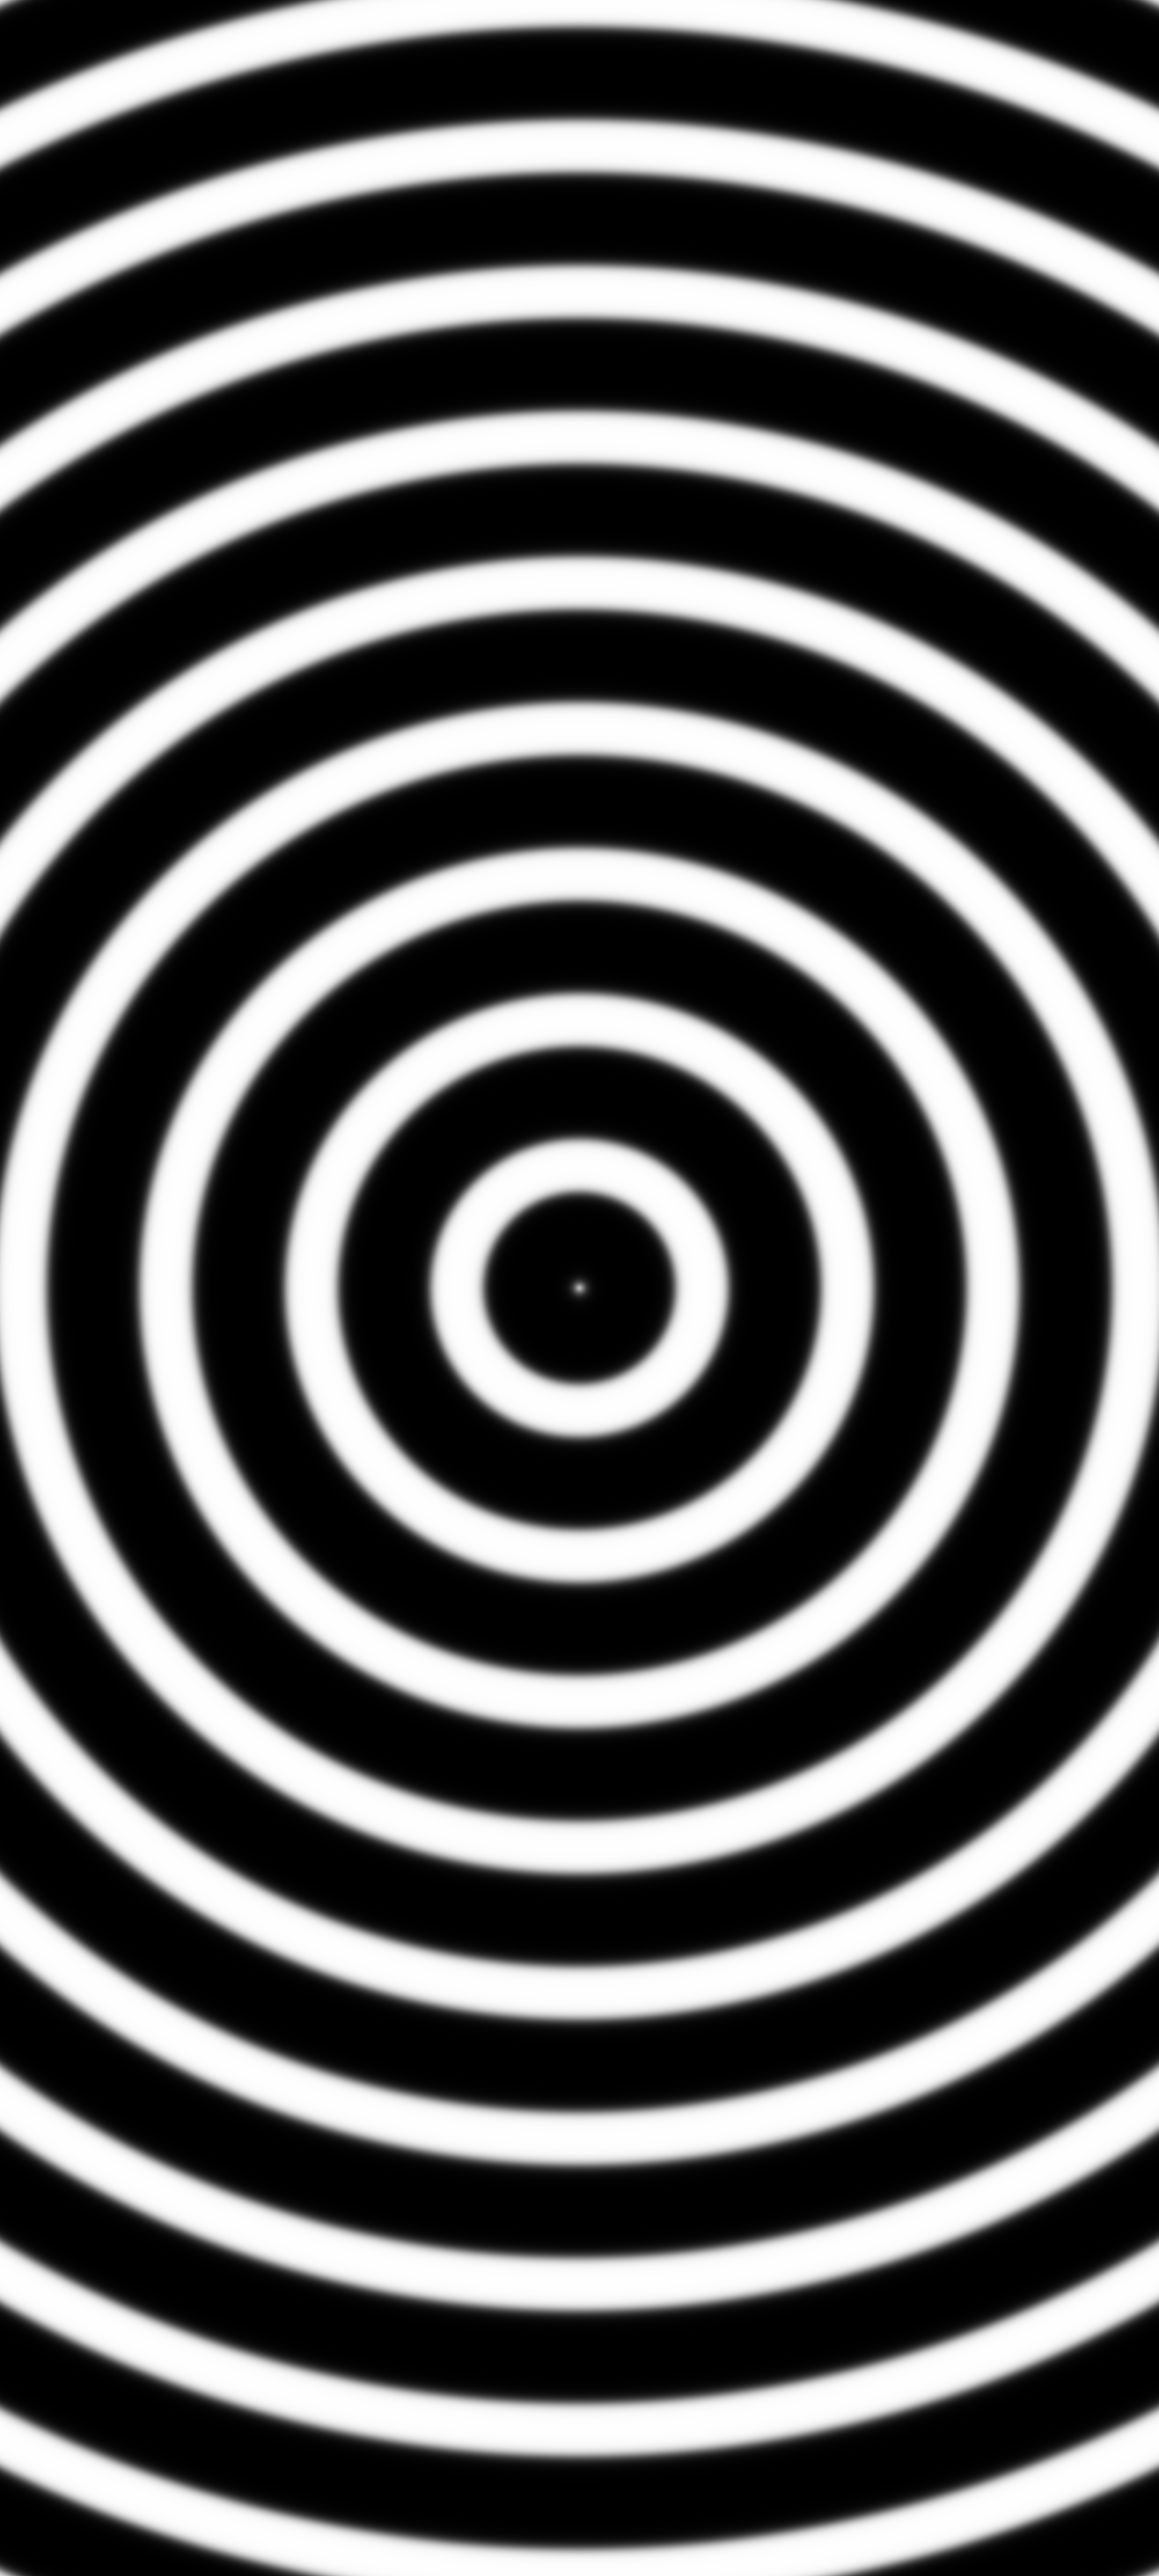

In [ ]:
res = (1080 * 2, 2400 * 2)
centre = (0, 0)
width = 50
pixel_ratio = 1
waves = make_switches(res, centre, width, pixel_ratio, phase=1, power=2, freq=1, push=6)
mpty_shit = np.zeros_like(waves)
additional = np.concatenate([waves, mpty_shit], -1)
mtx = create_color_generator_input_matrix(res, centre, width, pixel_ratio,
                                          effects_matrices=additional)[0]

print(mtx.shape)
print(mtx[..., 0])

vals = (((mtx[..., -2] + 1) / 2) * 255).astype(np.uint8)
Image.fromarray(vals)